In [482]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from copy import deepcopy
from collections import deque
import matplotlib.pyplot as plt
from pprint import pprint

np.set_printoptions(precision = 3)


---

## Question 2 - Blackjack with no Kings

### Part 1 - Defining the Environment

Below, we define the modified Blackjack environment as instructed. Do refer to inline comments for precise explanations on certain parts of the code

In [483]:
class BlackjackWithNoKings:
     
    def __init__(self):
        
        self.game_state = None
    
    def _get_state_dim(self):
        
        """
        State Dims:
        2: Player has Usable Ace or not
        10: Player's Hand sum (12 to 21)
        10: Dealer's visible card (Ace to 10)
        """
        
        return (2, 10, 10)
    
    def _get_action_dim(self):
        
        """
        Action Dims:
        2: Player can choose to Stand or Hit
        """
        
        return 2
    
    def _get_state_action_dim(self):
        
        """
        Combination of State and Action Dims described above
        """
        
        return tuple(list(self._get_state_dim()) + [self._get_action_dim()])
        
    def draw_card(self):
        
        # Equal probability to draw an Ace, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, J, Q - 13 possible card types
        card_index = np.random.randint(1, 13)
        
        card_value = min(card_index, 10)
        
        return card_index, card_value
    
    def _update_game_state(self):
        
        self.game_state = [1 if self.player_usable_ace else 0, self.player_sum, self.dealer_visible_card_value]
        
    def reset(self):
        
        # Initialize all relevant variables
        self.player_sum = 0
        self.player_cards_drawn = []
        self.player_usable_ace = False
        self.player_usable_ace_count = 0
        
        self.dealer_sum = 0
        self.dealer_cards_drawn = []        
        self.dealer_usable_ace = False
        self.dealer_usable_ace_count = 0
        self.dealer_visible_card_value = None
        
        # Initialize Player Hand - The player will keep drawing cards until their hand shows a minimum of 12, as before that it 
        # only makes sense to hit instead of stand - As such, state values showing player hand value range from 12 to 21
        while self.player_sum < 12:
            
            card_index, card_value = self.draw_card()
            
            self.player_sum += 11 if card_index == 1 else card_value
            
            # If a player draws a usable ace, we increment the usable ace flag and counter
            if card_index == 1:
                
                self.player_usable_ace_count += 1
                self.player_usable_ace = True
                
            # If a player busts but has a usable ace, we decrement the usable ace counter and player sum by 10,
            # showing that the player "used" the ace to save themselves from becoming bust
            if (self.player_usable_ace_count >= 1 and self.player_sum > 21):

                self.player_sum -= 10
                self.player_usable_ace_count -= 1
                
            if self.player_usable_ace_count == 0:
                
                self.player_usable_ace = False
                
            self.player_cards_drawn.append(card_index)
            
        # Initialize Dealer Hand - "Visible/First" Card - Only one card is drawn as only that is needed to initialize the game
        dealer_visible_card_index, self.dealer_visible_card_value = self.draw_card()
        
        self.dealer_sum += 11 if dealer_visible_card_index == 1 else self.dealer_visible_card_value
        
        if dealer_visible_card_index == 1:
        
            self.dealer_usable_ace_count += 1
            self.dealer_usable_ace = True
        
        self.dealer_cards_drawn.append(dealer_visible_card_index)
        
        # Return initialized game state
        # We use a helper function to "update" the game state which converts the boolean player_usable_ace flag into a binary
        # which will be required for array indexing by the agent Q_sa 
        self._update_game_state()
        
        return self.game_state
    

    def play(self, player_action):

        # If player chooses to Stand, Dealer's turn to finish their Hand (i.e. draw according to their until stopped or bust) 
        if player_action == 0:
            
            # Simulate rest of Dealer Hand
            while ((self.dealer_sum <= 16 and self.dealer_usable_ace == False) or (self.dealer_sum <= 17 and self.dealer_usable_ace == True)): # Dealer Policy

                card_index, card_value = self.draw_card()

                self.dealer_sum += 11 if card_index == 1 else card_value

                # Dealer follows same ace using logic as the player, described above. Will not repeat explanations here
                # to minimize comments
                if card_index == 1:

                    self.dealer_usable_ace_count += 1
                    self.dealer_usable_ace = True

                if (self.dealer_usable_ace_count >= 1 and self.dealer_sum > 21):

                    self.dealer_sum -= 10
                    self.dealer_usable_ace_count -= 1

                if self.dealer_usable_ace_count == 0:

                    self.dealer_usable_ace = False                

                self.dealer_cards_drawn.append(card_index)
                
            self._update_game_state()
            
            # We now check to see who won, and dole out rewards based on the rules defined in the question
            
            if self.dealer_sum > 21:
                
                return 1.5 if self.player_sum == 21 else 1, self.game_state, True
            
            elif self.player_sum > self.dealer_sum:
                
                return 1.5 if self.player_sum == 21 else 1, self.game_state, True
            
            elif self.player_sum == self.dealer_sum:
                
                return 0, self.game_state, True
            
            elif self.player_sum < self.dealer_sum:
                
                return -1, self.game_state, True
            
        # If player chooses to Hit, they draw 1 card at a time. If bust, then return loss rewards, state, done = True
        # If not bust, return zero rewards, state, done = False and agent will decide whether to Hit or Stand again 
        card_index, card_value = self.draw_card()

        self.player_sum += 11 if card_index == 1 else card_value

        if card_index == 1:

            self.player_usable_ace_count += 1
            self.player_usable_ace = True

        if (self.player_usable_ace_count >= 1 and self.player_sum > 21):

            self.player_sum -= 10
            self.player_usable_ace_count -= 1
            
        if self.player_usable_ace_count == 0:

            self.player_usable_ace = False  

        self.player_cards_drawn.append(card_index)
        
        self._update_game_state()

        if self.player_sum > 21:

            return -1, self.game_state, True
        
        assert self.player_sum <= 21
        
        return 0, self.game_state, False
        

---

### Part 2(a) - Defining the Monte Carlo Agent

Below, we define an agent which will be trained via Monte Carlo methods. We incorporate the ability to train using:

1. First Visit
2. Last Visit
3. On Policy
4. Off Policy methods

Performance of all 4 will be compared in the analysis section. For details on specifics of the code, do refer to comments inline:

In [484]:
class AgentMC:
    
    # we choose a gamma of 1.0 throughout this exercise as blackjack episodes are not very long and the reward received is nearly imminent
    def __init__(self, Env, epsilon = 0.1, gamma = 1.0):
        
        self.Env = Env
        self.gamma = gamma # discount rate
        self.epsilon = epsilon # default target policy exploration rate
        self.epsilon_b = 0.50 # behavioral policy exploration rate   
        self.delta = 1e-7 # delta for convergence condition
        
        self.state_dims = self.Env._get_state_dim()
        self.state_action_dims = self.Env._get_state_action_dim()
        
        # Order: Usable Ace, Player Sum, Dealer Visible Card (Ace index 0), Action
        self.V_s = np.zeros(self.state_dims)
        self.Q_sa = np.zeros(self.state_action_dims)
        self.Q_sa_history = []
        
        # Dictionary to store state-action pairs
        self.visits_sa = dict([((i, j, k, l), 0) for i in range(self.state_action_dims[0]) \
                                                 for j in range(self.state_action_dims[1]) \
                                                 for k in range(self.state_action_dims[2]) \
                                                 for l in range(self.state_action_dims[3]) \
                              ])
                
    # the target policy is epsilon greedy
    def target_policy(self, state, behavioral = False, act = False):
        
        state = deepcopy(state)
        
        # State and Next State values need to be adjusted such that indices fit within the Q_sa
        state[1] -= 12
        state[2] -= 1
        
        epsilon = self.epsilon_b if behavioral == True else self.epsilon 
        epsilon = epsilon if act == False else 0
        
        if np.random.rand() < epsilon:
            
            return np.random.choice(2) # random action
        
        else:
            
            max_q_value = np.max(self.Q_sa[tuple(state)])
            max_indices = np.where(self.Q_sa[tuple(state)] == max_q_value)[0]
            
            return np.random.choice(max_indices)
        
    # behavioral policy is also epsilon greedy, but with a higher epsilon value to encourage more exploration
    def behavioral_policy(self, state):
        
        return self.target_policy(state, behavioral = True)
    
    # returns an epsiode of a blackjack game (episode - start to finish)
    def sample_episode(self):
        
        episode = []
        state = self.Env.reset()
        
        done = False
        
        while not done:
            
            action = self.target_policy(state)            
            reward, next_state, done = self.Env.play(action)
            episode.append(deepcopy((state, action, reward)))
            state = next_state
        
        return episode
    
    # when agent is trained, this method performs the greedy action to maximise expected returns
    def act(self, state):
        
        return self.target_policy(state, act = True)

    # First Training paradigm - First Visit vs. Every Visit
    def predict_q(self, num_episodes, first_visit = True):
        
        self.name = f'Monte Carlo - {"First" if first_visit else "Every"} Visit'
        
        for _ in tqdm(range(num_episodes)):

            episode = self.sample_episode()
            G = 0
            visited_sa_pairs = set()

            future_rewards = np.zeros(len(episode))
            before_update = np.sum(deepcopy(self.Q_sa))
            self.Q_sa_history.append(before_update)
            
            for i, (state, action, reward) in enumerate(reversed(episode)):
                
                G = reward + self.gamma * G
                future_rewards[-(i+1)] = G

            for i, (state, action, reward) in enumerate(episode):
                
                state[1] -= 12
                state[2] -= 1
        
                G = future_rewards[i]
                sa_tuple = tuple(state+[action])

                if first_visit:
                    if sa_tuple in visited_sa_pairs:
                        continue
                    else:
                        visited_sa_pairs.add(sa_tuple)
                        
                self.visits_sa[sa_tuple] += 1
                self.Q_sa[sa_tuple] += 1/(self.visits_sa[sa_tuple]) * (G - self.Q_sa[sa_tuple])
                
            after_update = np.sum(deepcopy(self.Q_sa))
            delta = abs(after_update - before_update)

            # # The following convergence termination code has been commented out in order to allow all agents to be trained on an equal no. of iterations for analysis later on
            # if delta < self.delta and delta != 0 and delta >= 1e-13:
            #     print(f'[{self.name} - CONVERGED] Training Stopped at Episode {_}. Delta: {delta}')
            #     break        
            
    # Second Training paradigm - On Policy vs. Off Policy                
    def GPI(self, num_episodes, on_policy = True):
        
        self.name = f'Monte Carlo - {"On" if on_policy else "Off"} Policy'
        
        for _ in tqdm(range(num_episodes)):
            
            episode = []
            state = self.Env.reset()
            
            done = False
            
            while not done:
                
                if on_policy:
                    action = self.target_policy(state)
                else:
                    action = self.behavioral_policy(state)
                
                reward, next_state, done = self.Env.play(action)
                episode.append(deepcopy((state, action, reward)))
                state = next_state
                
            before_update = np.sum(deepcopy(self.Q_sa))
            self.Q_sa_history.append(before_update)

            G = 0
            W = 1  # Importance sampling ratio
            for state, action, reward in reversed(episode):
                
                state[1] -= 12
                state[2] -= 1
                
                sa_tuple = tuple(state + [action])

                G = reward + self.gamma * G
                self.visits_sa[sa_tuple] += W
                self.Q_sa[sa_tuple] += W / self.visits_sa[sa_tuple] * (G - self.Q_sa[sa_tuple])
                
                if not on_policy:
                    
                    behavior_prob = self.epsilon_b if action != np.argmax(self.Q_sa[tuple(state)]) else (1-self.epsilon_b) # chance of not following greedy under bp
                    target_prob = self.epsilon if action != np.argmax(self.Q_sa[tuple(state)]) else (1-self.epsilon) # chance of not following greedy under tp
                    
                    W *= target_prob / behavior_prob
                    
                    if W == 0:
                        break
                        
            after_update = np.sum(deepcopy(self.Q_sa))
            delta = abs(after_update - before_update)
            
            # # The following convergence termination code has been commented out in order to allow all agents to be trained on an equal no. of iterations for analysis later on
            # if delta < self.delta and delta != 0 and delta >= 1e-13:
            #     print(f'[{self.name} - CONVERGED] Training Stopped at Episode {_}. Delta: {delta}')
            #     break    


---

### Part 2(b) - Defining the TD Lambda Agent

Below, we define an agent which will be trained via TD Lambda methods. We incorporate the ability to train: 

1. Lambda = 1, On/Off Policy methods (Monte Carlo)
2. Lambda = 0, On/Off Policy methods (SARSA/Q-Learning)
3. Varying intermediate Lambda values, On/Off Policy methods

Performance of multiple combinations of these will be compared in the analysis section. For details on specifics of the code, do refer to comments inline:

In [485]:
class AgentTD:
    
    def __init__(self, Env, alpha = 0.1, gamma = 1.0, epsilon = 0.1, lambd = 0.9):
        
        self.Env = Env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.lambd = lambd
        self.delta = 1e-7  # delta for convergence condition
        
        self.state_dims = self.Env._get_state_dim()
        self.action_dims = self.Env._get_action_dim()
        self.state_action_dims = self.Env._get_state_action_dim()
        
        # Order: Usable Ace, Player Sum, Dealer Visible Card (Ace index 0), Action
        self.V_s = np.zeros(self.state_dims)
        self.Q_sa = np.zeros(self.state_action_dims)
        self.Et = np.zeros(self.state_action_dims)
        self.Q_sa_history = []
        self.delta_history = []
        
    # the default policy is epsilon greedy
    def epsilon_greedy_policy(self, state, act = False):
        
        state = deepcopy(state)
        
        # State values need to be adjusted such that indices fit within the Q_sa
        state[1] -= 12
        state[2] -= 1
        
        epsilon = self.epsilon if act == False else 0
        
        if np.random.rand() < epsilon:
        
            return np.random.choice(self.action_dims)
        
        else:
            
            max_q_value = np.max(self.Q_sa[tuple(state)])
            max_indices = np.where(self.Q_sa[tuple(state)] == max_q_value)[0]
            
            return np.random.choice(max_indices)
        
    # when agent is trained, this method performs the greedy action to maximise expected returns
    def act(self, state):
        
        return self.epsilon_greedy_policy(state, act = True)
    
    def train(self, num_episodes, on_policy = True):
        
        self.name = f'TD Lambda {self.lambd} - {"On" if on_policy else "Off"} Policy{" - MC" if self.lambd == 1 else ((" - SARSA" if on_policy else " - Q-Learning") if self.lambd == 0 else "")}'
        
        for _ in tqdm(range(num_episodes)):
            
            episode_memory = [] # to be used when lambd = 1.0
            self.Et *= 0
            state = self.Env.reset()
            action = self.epsilon_greedy_policy(state)
            
            done = False
            end_loop = False
            before_update = np.sum(deepcopy(self.Q_sa))
            self.Q_sa_history.append(before_update)
            
            while not done:
                
                reward, next_state, done = self.Env.play(action)
                
                next_action = self.epsilon_greedy_policy(next_state) if not done else 0
                
                adj_state = deepcopy(state)
                adj_next_state = deepcopy(next_state)
                
                adj_state[1] -= 12
                adj_state[2] -= 1        

                adj_next_state[1] -= 12
                adj_next_state[2] -= 1    
                
                adj_next_state_tuple = tuple(adj_next_state)
                adj_sa_tuple = tuple(adj_state + [action])
                adj_next_sa_tuple = tuple(adj_next_state + [next_action])            
                
                if self.lambd == 1.0:
                    
                    episode_memory.append((adj_state, action, reward))
                    state, action = next_state, next_action
                    continue
                    
                if not done:

                    if on_policy: # sarsa

                        delta = reward + self.gamma * self.Q_sa[adj_next_sa_tuple] - self.Q_sa[adj_sa_tuple]

                    else: # q-learning

                        best_next_action = np.argmax(self.Q_sa[adj_next_state_tuple])
                        delta = reward + self.gamma * self.Q_sa[tuple(adj_next_state + [best_next_action])] - self.Q_sa[adj_sa_tuple]
                        
                else: # terminal state returns are zero
                    
                    delta = reward + self.gamma * 0 - self.Q_sa[adj_sa_tuple]
                
                self.Et[adj_sa_tuple] += 1
                self.Q_sa += self.alpha * delta * self.Et
                self.Et *= self.gamma * self.lambd
                
                state, action = next_state, next_action
                
                self.delta_history.append(abs(delta))
                # # The following convergence termination code has been commented out in order to allow all agents to be trained on an equal no. of iterations for analysis later on
                # if abs(delta) < self.delta and delta != 0 and delta >= 1e-13:
                #     print(f'[{self.name} - CONVERGED] Training Stopped at Episode {_}. Delta: {delta}')
                #     done = True
                #     end_loop = True
            
#             if end_loop:
#                 break
            
            if self.lambd == 1.0:
                
                G = 0
                
                for state, action, reward in reversed(episode_memory):
                    
                    sa_tuple = tuple(state + [action])
                    G = reward + self.gamma * G
                    self.Q_sa[sa_tuple] += self.alpha * (G - self.Q_sa[sa_tuple])
                    
                after_update = np.sum(deepcopy(self.Q_sa))
                delta = abs(after_update - before_update)
                
                # # The following convergence termination code has been commented out in order to allow all agents to be trained on an equal no. of iterations for analysis later on
                # if delta < self.delta and delta != 0 and delta >= 1e-13:
                #     print(f'[{self.name} - CONVERGED] Training Stopped at Episode {_}. Delta: {delta}')
                #     break
                

---

### Part 3 - Models Training

Now that we have defined the agents above, we train a set of 10 agents with 500k iterations each. Early termination code was commented out above in order to give each agent an equal footing when being compared in the analysis section later on:

1. MC First Visit
2. MC Every Visit
3. MC On Policy
4. MC Off Policy
5. TD Lambda (1) - MC - On Policy
6. TD Lambda (1) - MC - Off Policy
7. TD Lambda (0) - SARSA - On Policy
8. TD Lambda (0) - Q-Learning - Off Policy
9. TD Lambda (0.5) - On Policy
10. TD Lambda (0.5) - Off Policy


In [472]:
# Trained models will be saved into this list for analysis later
trained_blackjack_agents = []

# Monte Carlo First Visit
player_MC_first_visit = AgentMC(BlackjackWithNoKings())
player_MC_first_visit.predict_q(500000, first_visit = True)
trained_blackjack_agents.append(player_MC_first_visit)

# Monte Carlo Every Visit
player_MC_every_visit = AgentMC(BlackjackWithNoKings())
player_MC_every_visit.predict_q(500000, first_visit = False)
trained_blackjack_agents.append(player_MC_every_visit)

# Monte Carlo On Policy
player_MC_on_policy = AgentMC(BlackjackWithNoKings())
player_MC_on_policy.GPI(500000, on_policy = True)
trained_blackjack_agents.append(player_MC_on_policy)

# Monte Carlo Off Policy
player_MC_off_policy = AgentMC(BlackjackWithNoKings())
player_MC_off_policy.GPI(500000, on_policy = False)
trained_blackjack_agents.append(player_MC_off_policy)

# TD Lambda MC - On Policy
player_TDL1_on_policy = AgentTD(BlackjackWithNoKings(), lambd = 1.0)
player_TDL1_on_policy.train(500000, on_policy = True)
trained_blackjack_agents.append(player_TDL1_on_policy)

# TD Lambda MC - Off Policy
player_TDL1_off_policy = AgentTD(BlackjackWithNoKings(), lambd = 1.0)
player_TDL1_off_policy.train(500000, on_policy = False)
trained_blackjack_agents.append(player_TDL1_off_policy)

# SARSA
player_TDL_sarsa = AgentTD(BlackjackWithNoKings(), lambd = 0.0)
player_TDL_sarsa.train(500000, on_policy = True)
trained_blackjack_agents.append(player_TDL_sarsa)

# Q-Learning
player_TDL_qlearning = AgentTD(BlackjackWithNoKings(), lambd = 0.0)
player_TDL_qlearning.train(500000, on_policy = False)
trained_blackjack_agents.append(player_TDL_qlearning)

# TD Lambda 0.5 - On Policy
player_TDL0_5_on_policy = AgentTD(BlackjackWithNoKings(), lambd = 0.5)
player_TDL0_5_on_policy.train(500000, on_policy = True)
trained_blackjack_agents.append(player_TDL0_5_on_policy)

# TD Lambda 0.5 - Off Policy
player_TDL0_5_off_policy = AgentTD(BlackjackWithNoKings(), lambd = 0.5)
player_TDL0_5_off_policy.train(500000, on_policy = False)
trained_blackjack_agents.append(player_TDL0_5_off_policy)


100%|████████████████████████████████████████████████████████████████████████| 500000/500000 [01:29<00:00, 5558.49it/s]


In [478]:
# Defining a helper function to assist in testing the trained agents above, and plotting the Q_sa values later during the analysis phase

def play_test(agent, n):
    
    win = 0
    blackjack = 0
    tie = 0
    loss = 0

    for i in range(n):

        env = BlackjackWithNoKings()
        state = env.reset()
        total_reward = 0
        done = False

        while not done:

            action = agent.act(state)
            reward, next_state, done = env.play(action)
            state = next_state
            total_reward += reward

        if reward == 0:
            tie += 1
        if reward == 1.5:
            win += 1
            blackjack += 1
        if reward == 1:
            win += 1
        if reward == -1:
            loss += 1
            
    results_dict = {}
    
    results_dict['Non-Blackjack Win Rate'] = (won - blackjack) / num_games
    results_dict['Blackjack Win Rate'] = blackjack / num_games
    results_dict['Win Rate'] = win / num_games
    results_dict['Tie Rate'] = tie / num_games
    results_dict['Loss Rate'] = loss / num_games
    results_dict['Expected Return'] = results_dict['Non-Blackjack Win Rate'] * 1 + results_dict['Blackjack Win Rate'] * 1.5 + results_dict['Loss Rate'] * -1
    
    return results_dict

def plotter(agent):
    
    fig = plt.figure(figsize = (15, 9))
    
    ax0 = fig.add_subplot(121, projection = '3d')
    ax1 = fig.add_subplot(122, projection = '3d')

    for idx, ua in enumerate(agent.Q_sa):    

        player_sums = []
        dealer_visible_cards = []
        max_values = []
        actions = []

        for ps in range(10):

            for dv in range(10):

                max_value = -1e6
                action = None

                for i, v in enumerate(ua[ps][dv]):

                    if v > max_value:

                        max_value = v
                        action = i

                player_sums.append(ps + 12)
                dealer_visible_cards.append(dv)
                max_values.append(max_value)
                actions.append('r' if action == 0 else 'g')

        eval(f'ax{idx}').bar3d(dealer_visible_cards, player_sums, 0, width, depth, max_values, shade = True, color = actions)
        eval(f'ax{idx}').set_title(f'{"No " if idx == 0 else ""}Usable Ace')
        
        eval(f'ax{idx}').set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
        eval(f'ax{idx}').set_yticks([12, 13, 14, 15, 16, 17, 18, 19, 20, 21])        
        
        eval(f'ax{idx}').set_xlabel('Dealer displayed card value (Ace = 1)', labelpad = 20)
        eval(f'ax{idx}').set_ylabel('Player Hand Sum', labelpad = 15)
        eval(f'ax{idx}').set_zlabel('Expected Reward following Best Action', labelpad = 10)
        
        eval(f'ax{idx}').tick_params(axis = "x", pad = 15)
        eval(f'ax{idx}').tick_params(axis = "y", pad = 10)
        eval(f'ax{idx}').tick_params(axis = "z", pad = 5)
        
    fig.suptitle(f'Final Q_sa plot for {agent.name} after 500k training iterations', fontsize = 16)
    plt.tight_layout()
    plt.show()


---

### Part 4(a) - Analysis - Generating Agents' Win Rates

Now that we have trained 10 agents, we use the learned policies to simulate 100k games, to determine what are the win/blackjack/tie/loss rates for each agent. Then, within the MC and TDL families of agents, we will pick the best agents and conducted a deeper analysis on their convergence, state-action values and policies

In [474]:
# Run 100k simulated games per agent to see which ones perform best
key_result_columns = ['Expected Return', 'Win Rate']
results_dict = {}

for agent in tqdm(trained_blackjack_agents):
    
    results_dict[agent.name] = play_test(agent, 100000)
    
df = pd.DataFrame(results_dict).T
cols = df.columns.tolist()
cols = [cols[-1]] + [cols[2]] + cols[:2] + cols[3:5]
df = df[cols]


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:35<00:00,  9.59s/it]


In [475]:
# Generate results table for Monte Carlo agents
mc_results_df = df.filter(like = 'Monte Carlo', axis = 0)
mc_results_df = mc_results_df.style.set_properties(**{'background-color':'gold'}, subset = key_result_columns)\
                             .highlight_max(props = 'color:green;font-weight: bold', axis = 0, subset = key_result_columns)\
                             .format({
                                      'Win Rate': '{:,.2%}'.format,
                                      'Non-Blackjack Win Rate': '{:,.2%}'.format,
                                      'Blackjack Win Rate': '{:,.2%}'.format,
                                      'Tie Rate': '{:,.2%}'.format,
                                      'Loss Rate': '{:,.2%}'.format,
                                     })
mc_results_df


,Expected Return,Win Rate,Non-Blackjack Win Rate,Blackjack Win Rate,Tie Rate,Loss Rate
Monte Carlo - First Visit,-0.015250,42.32%,31.00%,10.14%,9.96%,47.73%
Monte Carlo - Every Visit,-0.020640,42.08%,30.87%,10.26%,9.59%,48.33%
Monte Carlo - On Policy,-0.016355,42.54%,30.90%,10.23%,9.58%,47.88%
Monte Carlo - Off Policy,-0.022155,41.21%,30.09%,11.04%,9.92%,48.87%


Viewing the results for the Monte Carlo Agents, above we see that **the Monte Carlo - On Policy  agent has the best win rate of 42.54%** while **the Monte Carlo - First Visit agent has the best expected return of -0.015250**, which is computed based on the Win Rates multiplied by the expected rewards of a standard win, blackjack win or a loss.

*Nevertheless, we note that all MC models are very close in their results, and based on empirical studies conducted across multiple runs, the best model can change from training run to training run (i.e., Prof, when you run the models, the best ones may not be the same as the ones I wrote above)*

---

In [476]:
# Generate results table for TD Lambda agents
td_results_df = df.filter(like = 'TD Lambda', axis = 0)
td_results_df = td_results_df.style.set_properties(**{'background-color':'gold'}, subset = key_result_columns)\
                             .highlight_max(props = 'color:green;font-weight: bold', axis = 0, subset = key_result_columns)\
                             .format({
                                      'Win Rate': '{:,.2%}'.format,
                                      'Non-Blackjack Win Rate': '{:,.2%}'.format,
                                      'Blackjack Win Rate': '{:,.2%}'.format,
                                      'Tie Rate': '{:,.2%}'.format,
                                      'Loss Rate': '{:,.2%}'.format,
                                     })
td_results_df


,Expected Return,Win Rate,Non-Blackjack Win Rate,Blackjack Win Rate,Tie Rate,Loss Rate
TD Lambda 1.0 - On Policy - MC,-0.034550,41.18%,31.10%,10.03%,9.22%,49.60%
TD Lambda 1.0 - Off Policy - MC,-0.041620,41.34%,31.96%,9.18%,8.78%,49.88%
TD Lambda 0.0 - On Policy - SARSA,-0.027550,41.52%,30.28%,10.85%,9.17%,49.31%
TD Lambda 0.0 - Off Policy - Q-Learning,-0.029445,41.21%,30.51%,10.62%,9.40%,49.39%
TD Lambda 0.5 - On Policy,-0.041305,41.06%,31.37%,9.76%,8.80%,50.14%
TD Lambda 0.5 - Off Policy,-0.028945,40.93%,30.72%,10.41%,9.84%,49.23%


Viewing the results for the TD Lambda Agents above, we see that **the TD Lambda (0) - On Policy - SARSA agent has both the best win rate of 41.52% and the best expected return of -0.027550**

*Nevertheless, we note that all TD models are very close in their results, and based on empirical studies conducted across multiple runs, the best model can change from training run to training run (i.e., Prof, when you run the models, the best ones may not be the same as the ones I wrote above)*

---

### Part 4(b) - Analysis - Deep Dive on Convergence and State-Action values

In this section, we take a look at how two models have converged and what the visualization of their state-action values tells us. For simplicity's sake, we choose one top model from the Monte Carlo methods and TD Lambda methods each to analyse further. We choose the model with the higher Expected Return, as maximising that is the key objective of a Blackjack player.

The code below dynamically identifies and extracts the two MC and TD models with the highest expected win-rate and plots based on that. As such, due to variability in training, the what I write in my analysis may not refer to the exact same models selected if the training is re-run on your end (which I know you will do Prof!)

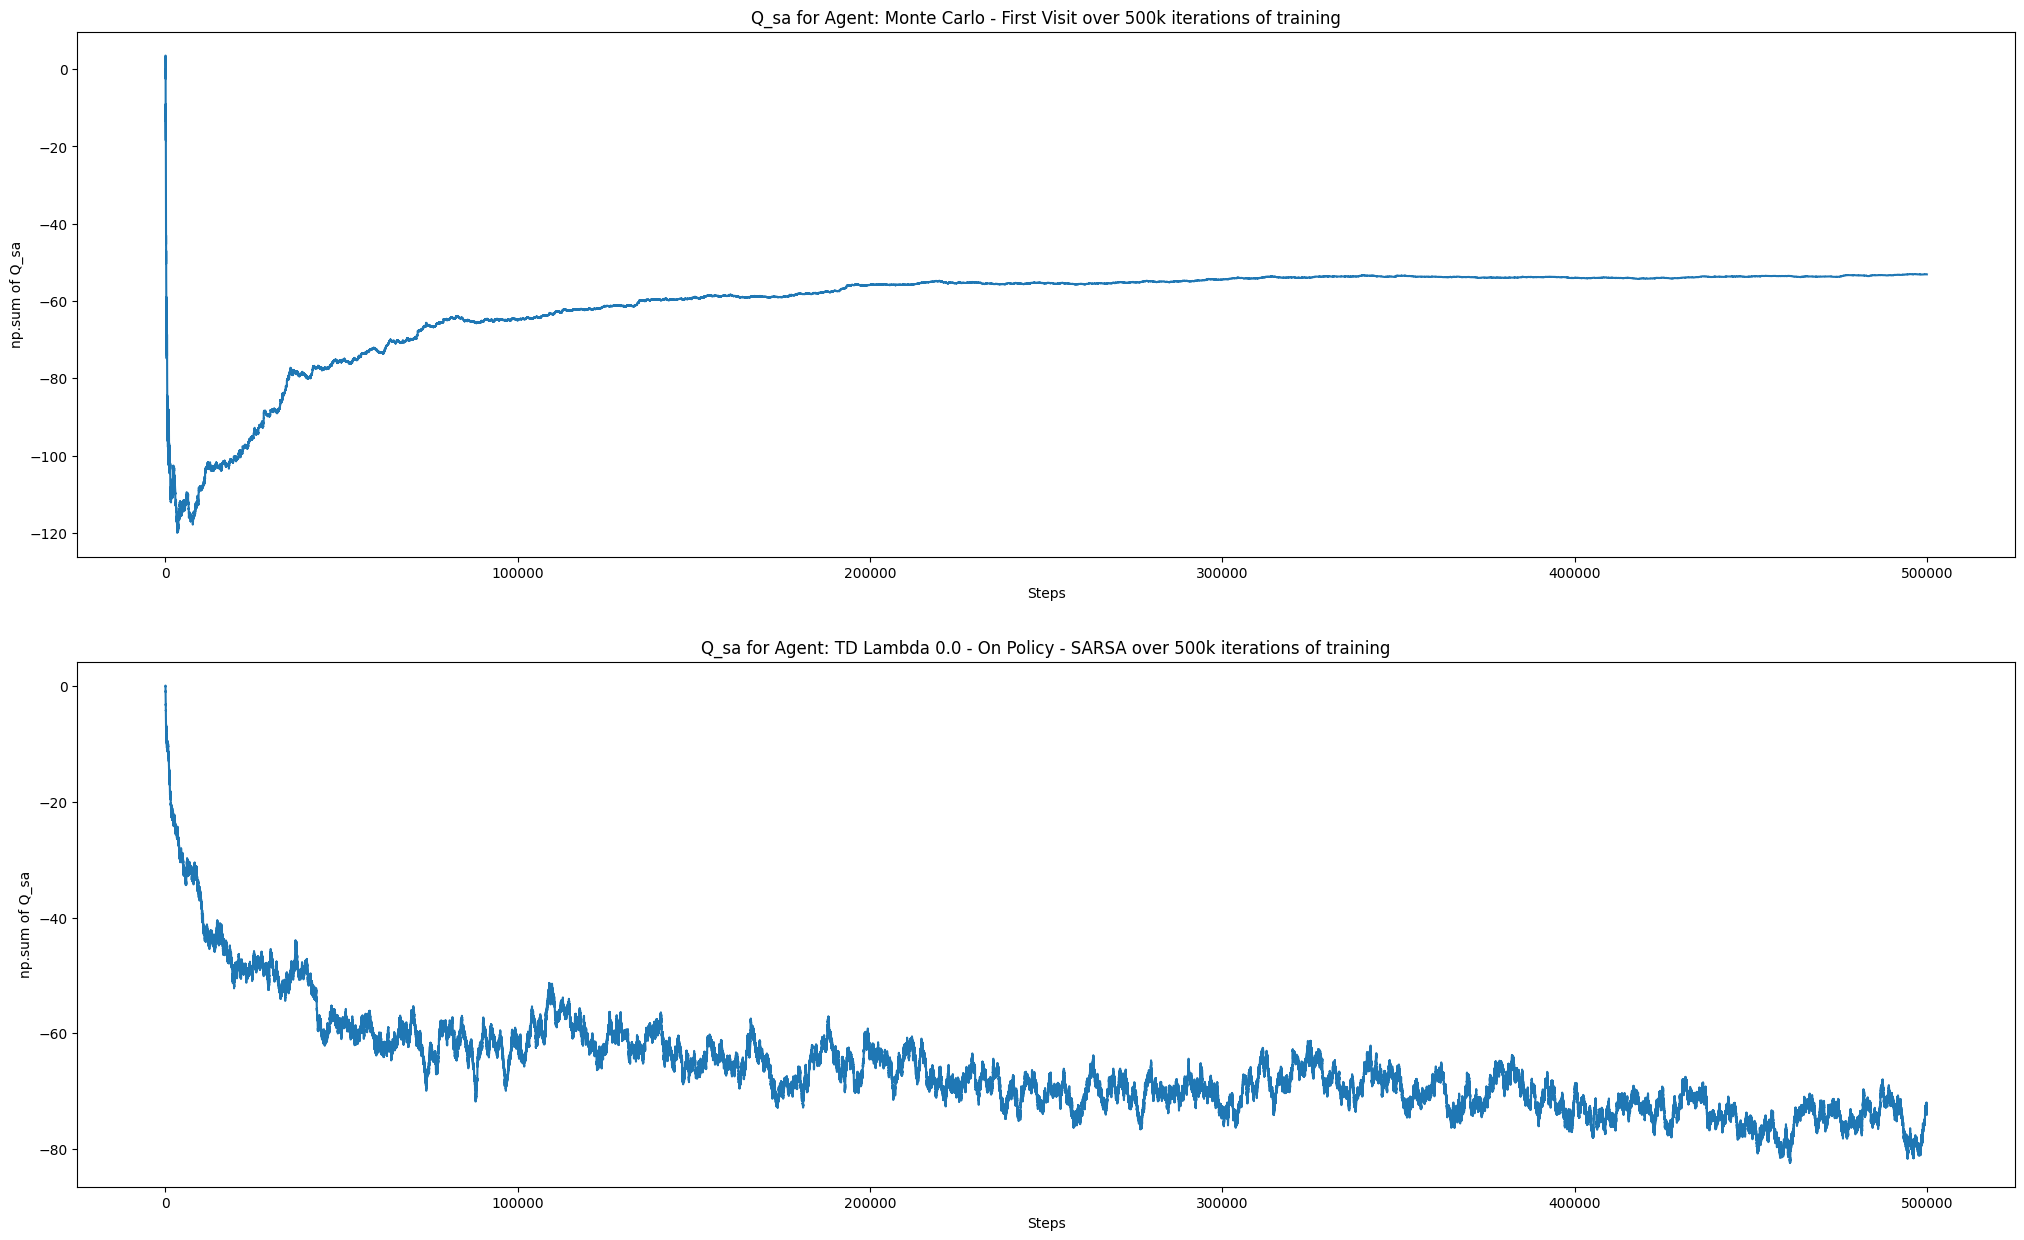

In [477]:
best_model_names = [df.filter(like = 'Monte Carlo', axis = 0).idxmax(axis = 0)['Expected Return'], df.filter(like = 'TD Lambda', axis = 0).idxmax(axis = 0)['Expected Return']]
best_agents = []
for agent in trained_blackjack_agents:
    if agent.name in best_model_names:
        best_agents.append(agent)

# Code to plot Q_sa, to illustrate convergence of both models

fig, ax = plt.subplots(2, 1, figsize = (25, 15))

for i in range(len(ax)):
        
    subplot = ax[i]
    subplot.plot(best_agents[i].Q_sa_history)
    subplot.set_xlabel('Steps')
    subplot.set_ylabel('np.sum of Q_sa')
    subplot.set_title(f'Q_sa for Agent: {best_agents[i].name} over 500k iterations of training')

plt.show()

From the above plots, we can firstly, clearly see that the Monte Carlo agent has converged at a np.sum(Q_sa) of around -60, around 200k iterations. However for the TD Lambda agent, the convergence is not as clear. From around 200k iterations ownards, the np.sum(Q_sa) fluctuates between -60 and -80, and continues to decrease at a much slower rate vs. the increasing number of iterations. While the convergence is not as clear as the Monte Carlo agent, we can conclude that sufficient convergence has occured in the TD Lambda agent, since it seems to be relatively stable within a defined range, and complete convergence may require an infeasible number of training iterations.

---

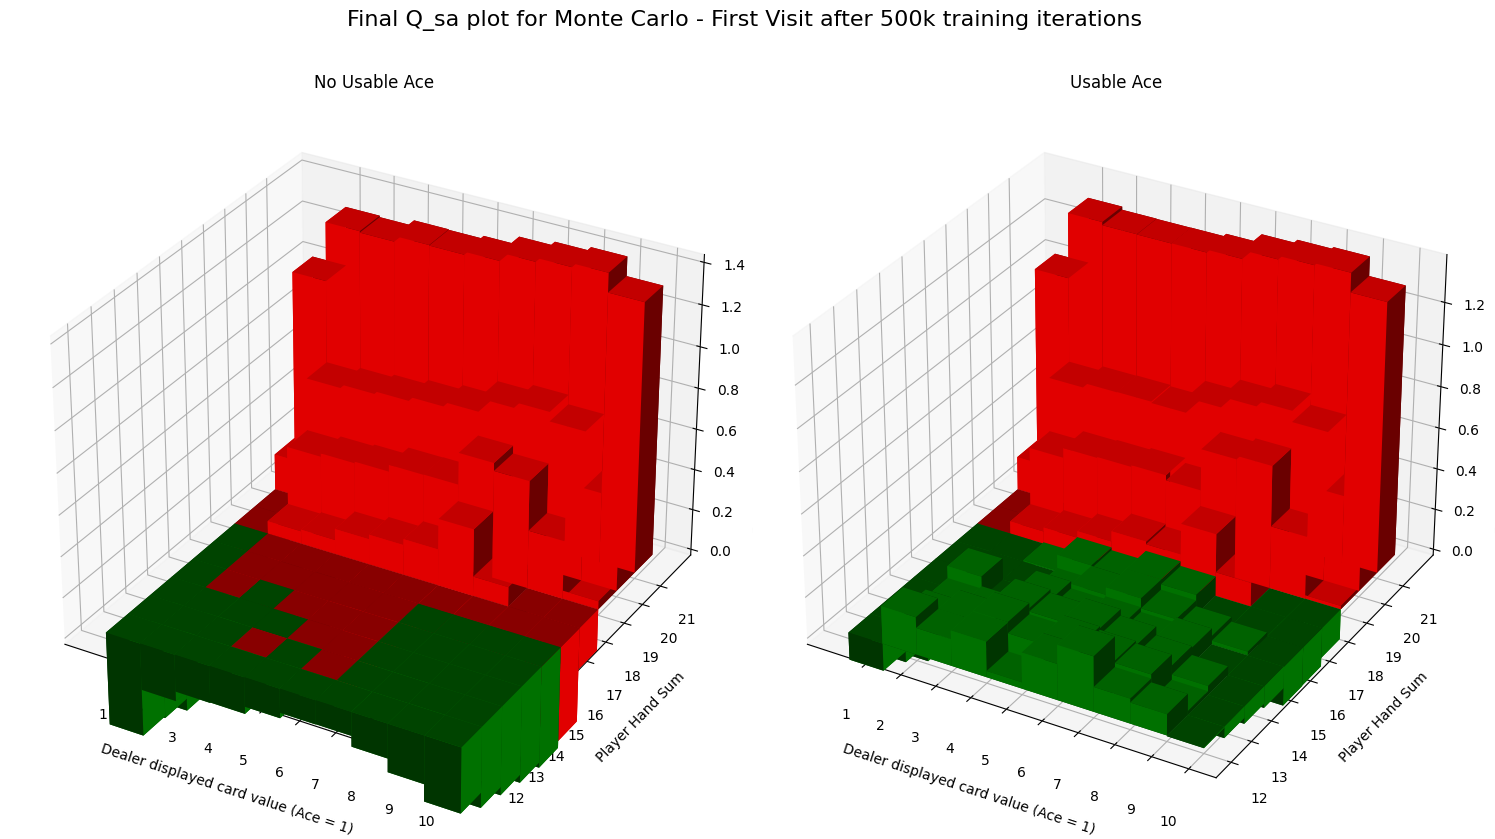

In [481]:
plotter(best_agents[0])

For the plot above, the <font color='green'>**green**</font> regions indicate states where the best action taken is to <font color='green'>**Hit**</font>. Conversely, the <font color='red'>**red**</font> regions indicate states where the best action taken is to <font color='red'>**Stand**</font> - Essentially, the Greedy Policy learned.

We can see that the higher the starting value of a player's hand, the agent has learned to <font color='red'>**Stand**</font>, and subsequently attain a higher Expected Reward, indicated by the "wall of red" towards the back of the plot above. Conversely, the lower the starting value of a player's hand, the agent has learned to <font color='green'>**Hit**</font>, but despite this, the Expected Reward tends to be mostly negative, or only very slightly positive in the "Usable Ace" case. Intuitively, this makes sense, as this game is ultimately designed to make the house money over the long run. This is further corroborated by the fact that the Expected Reward we saw for this agent above is **-0.015250** - Being slightly negative ensures that in the long run, the player is never the bigger winner than the house.

Comparing the No Usable Ace vs. the Usable Ace plots, we see that having a Usable Ace certainly has its advantages, as even at smaller Player Hand sums, one can still Expect a slight positive reward compared to not having a Usable Ace. It is however, interesting to note that while in the Usable Ace plot, at smaller Player Hand sums, the actions is almost always to <font color='green'>**Hit**</font>, while in the No Usable Ace plot, at smaller Player Hand sums, some actions still include <font color='red'>**Stand**</font>. One possible reason for this could be that due to the lack of a Usable Ace, the agent is risk-averse in taking more cards, as may be relying on the Dealer to go bust instead. Further studies need to be conducted (or more training) to conclusive understand why such a phenomenon is taking place - perhaps this could also be a nuance of the current training cycle, where more iterations could convert that central red-region to green.  

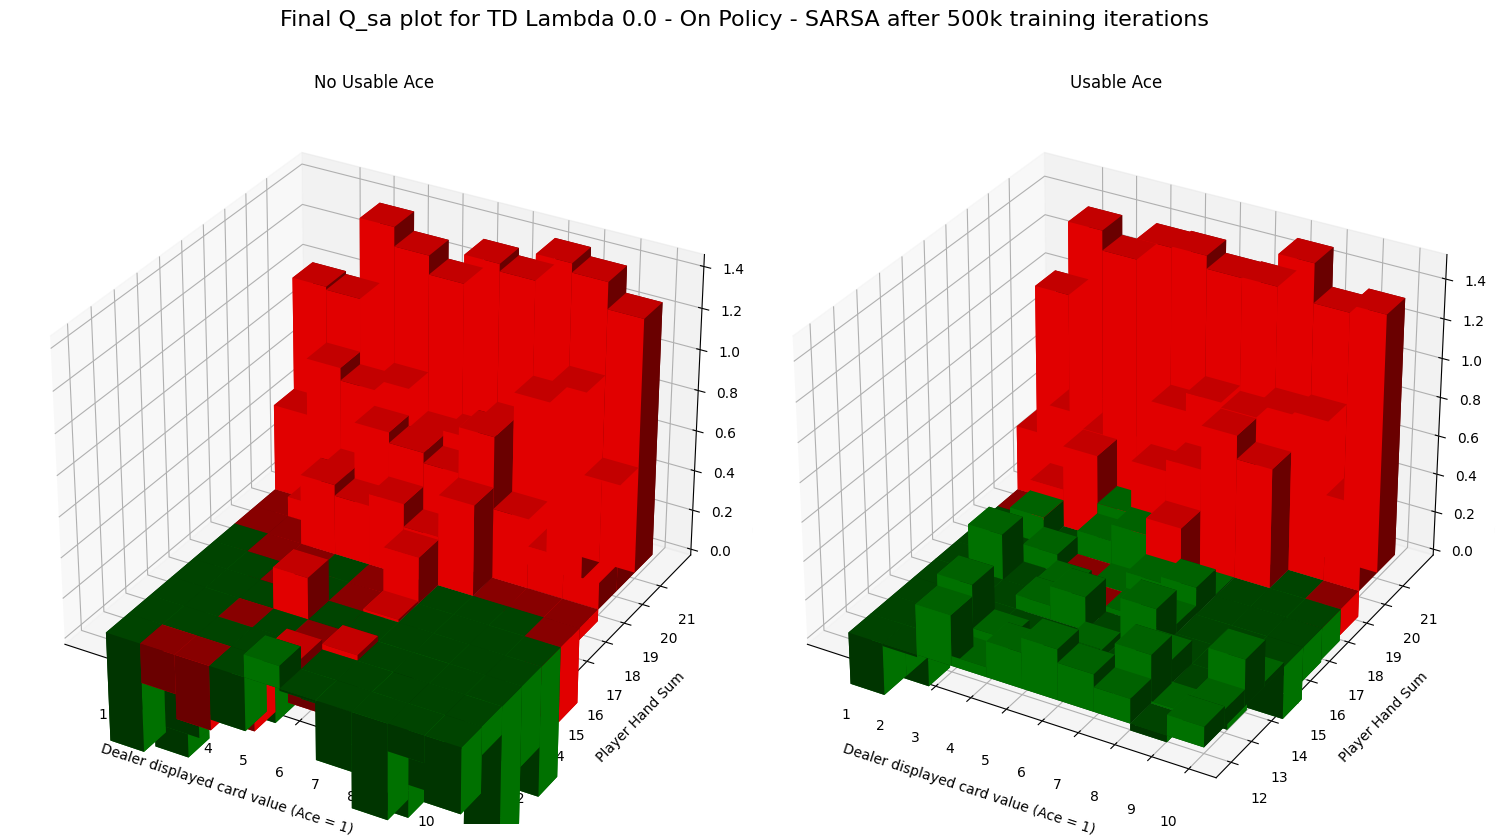

In [480]:
plotter(best_agents[1])

For the plot above, the <font color='green'>**green**</font> regions indicate states where the best action taken is to <font color='green'>**Hit**</font>. Conversely, the <font color='red'>**red**</font> regions indicate states where the best action taken is to <font color='red'>**Stand**</font> - Essentially, the Greedy Policy learned.


The TD Lambda Q_sa plots broadly look quite similar to the Monte Carlo plots, aside from the fact that they are bit more uneven. A few key differences to note (i) the No Usable Ace plot tends to have lower negative expected Q_sa values when the Player Hand sum is low - this likely contributes to the overall lower win rate and lower expected returns of the best TD Lambda model vs. the best Monte Carlo model (ii) The Usable Ace plot has slightly higher values across all its states, most prominently shown by states where the Player Hand sum is low, where the peaks a higher vs. the Monte Carlo plot. Again, while this should lead to better win rates and expected returns vs. Monte Carlo, the much bigger negative values in TD Lambda's No Usable Ace plot negates this slight advantage.

One conclusion we can draw however, is that both algorithms seem to have converged to very similar policies, with the green zones (Action: <font color='green'>**Hit**</font>) being in areas where the Player Hand sum is low, and the red zones (Action: <font color='red'>**Stand**</font>) being in areas where the Player Hand sum is high, correctly learning that it is better to <font color='green'>**Hit**</font> when the risk of busting is lower, and hence aligns with logical explanations.

---

### Part 5 - Conclusion and Suggestions

Overall, from the results observed above, we can conclude that they are in line with expectations. A quick Google search suggests that the average win-rate of Blackjack hovers between 40-45%. This is in line with our results, where the best Monte Carlo and TD Lambda models achieve a win rate of **42.54%** and **41.52%** respectively. The expected return also aligns with expectations, as in the long run and over a large number of games, the house always wins more than the players to make money.

One possible improvement I can think of is training a functional approximator on this modified Blackjack game instead of using conventional MC and TD methods. A functional approximator (such as PPO, DQN, from sb3) would be able to traing a target and online network together, and given the greater ability of NNs to store parameters and make more complex decisions, could ultimately improve the win rates for algorithms learning to play this modified version of Blackjack.

---

### References

The following GitHub repositories were used as reference in building the environment and agent scripts:

1. https://github.com/kavisherlock/BlackJack-RL/blob/master/TDLearningPlayer.py
2. https://github.com/jovsa/rl-examples-sutton-and-barto-book/blob/master/chapter05/blackjack.py

---